## **1. Setting**

In [ ]:
# drive.mount
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# import library
import math
import pandas as pd
import numpy as np

import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import RobustScaler

import warnings
warnings.filterwarnings('ignore')

pd.set_option('float_format', '{:f}'.format)

## **2. Read Data**

In [ ]:
# import data
PATH = "dir/"

df = pd.read_csv(PATH + "train.csv")
test = pd.read_csv(PATH + "test.csv")
pseudolabels = pd.read_csv(PATH + "tps12-pseudolabels_v2.csv")

# data shape
df.shape, test.shape, pseudolabels.shape

((4000000, 56), (1000000, 55), (984711, 56))

## **3. Reduce Data Size**

In [ ]:
# reference : https://www.kaggle.com/c/tabular-playground-series-dec-2021/discussion/291844
def reduce_mem_usage(df, verbose = True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024 ** 2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024 ** 2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

df = reduce_mem_usage(df)
test = reduce_mem_usage(test)
pseudolabels = reduce_mem_usage(pseudolabels)

Mem. usage decreased to 259.40 Mb (84.8% reduction)
Mem. usage decreased to 63.90 Mb (84.8% reduction)
Mem. usage decreased to 63.86 Mb (84.8% reduction)


## **4. EDA**

In [ ]:
## train 및 test data 모두 결측치 없음
# df.isnull().sum()

# def countmissing(dataset) :
#   msno.matrix(dataset)
#   plt.show()

#   msno.bar(dataset)
#   plt.show()

# countmissing(df)

In [ ]:
# target value를 제외하고 모두 동일
df.columns.difference(test.columns)

## train 및 test data 모두 중복값 없음
# df.T.duplicated()

## (참고) 중복값 제거
# df.drop_duplicates(keep = "first", inplace = True)

Index(['Cover_Type'], dtype='object')

In [ ]:
# target value distribution
print("The target class distribution:")
print((df.groupby('Cover_Type').Id.nunique() / len(df)).apply(lambda p: f"{p:.3%}"))

The target class distribution:
Cover_Type
1    36.703%
2    56.552%
3     4.893%
4     0.009%
5     0.000%
6     0.286%
7     1.557%
Name: Id, dtype: object


In [ ]:
# https://www.kaggle.com/odins0n/tps-dec-eda-modeling
target_df = pd.DataFrame(df['Cover_Type'].value_counts()).reset_index()
target_df.columns = ['Cover_Type', 'count']
fig = px.bar(data_frame = target_df, 
             x = 'Cover_Type',
             y = 'count', 
             color = "count",
             color_continuous_scale = 'Emrld') 
fig.show()

In [ ]:
# is it categorical feature?
columns_categorical = []
columns_continuous = []
def is_categorical(data, column):
    if len(data[column].unique()) <= 20:
        #print(str(column) + ": " + str(data[column].unique()))
        if column != 'Cover_Type':
          columns_categorical.append(column)
    else:
        #print(str(column) + ": " + "numerical feature !")
        if column != 'Id':
          columns_continuous.append(column)
    return 

## check feature type - train
#print('-'*30 + 'Train' + '-'*30)
columns_train = df.columns.to_list()
for column in columns_train:
    is_categorical(df, column)

print(f'Total number of features: {len(columns_train)}')
print(f'Number of categorical features: {len(columns_categorical)}')
print(f'Number of continuos features: {len(columns_continuous)}')

## check feature type - test
# print('-'*30 + 'Test' + '-'*30)
# columns_test = test.columns.to_list()
# for column in columns_train:
#     is_categorical(df, column)

Total number of features: 56
Number of categorical features: 44
Number of continuos features: 10


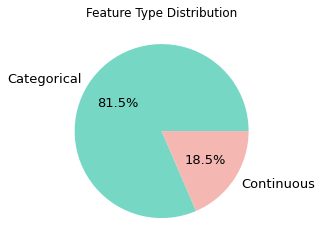

In [ ]:
# feature type visualization
plt.pie([len(columns_categorical), len(columns_continuous)], 
        labels = ['Categorical', 'Continuous'],
        colors = ['#76D7C4', '#F5B7B1'],
        textprops = {'fontsize': 13},
        autopct = '%1.1f%%')
plt.title("Feature Type Distribution")
plt.show()

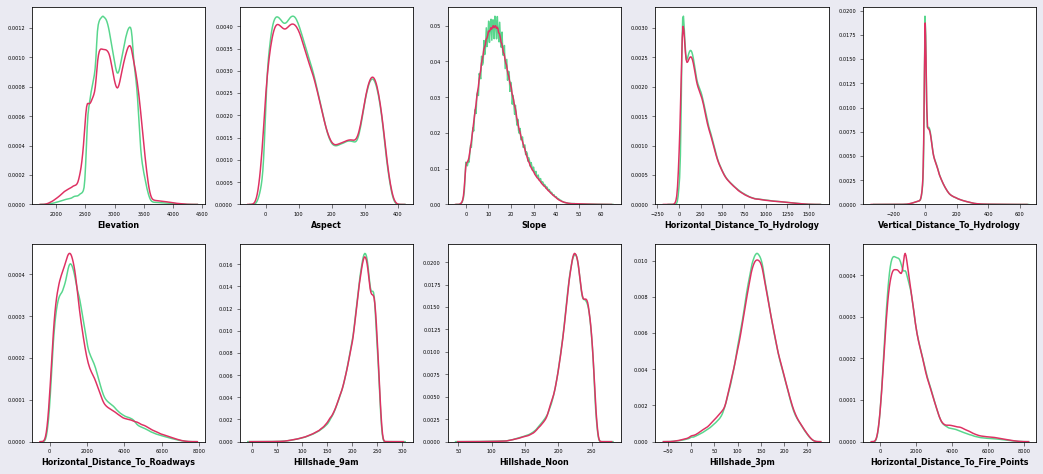

In [ ]:
# continuous feature distribution
ncols = 5
nrows = int(len(columns_continuous) / ncols + (len(columns_train) % ncols > 0)) - 1
fig, axes = plt.subplots(nrows, ncols, figsize = (18, 8), facecolor = '#EAEAF2')

for r in range(nrows):
    for c in range(ncols):
        col = columns_continuous[r * ncols + c]
        sns.kdeplot(x = df[col], ax = axes[r, c], color = '#58D68D', label = 'Train data')
        sns.kdeplot(x = test[col], ax = axes[r, c], color = '#DE3163', label = 'Test data')
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize = 8, fontweight = 'bold')
        axes[r, c].tick_params(labelsize = 5, width = 0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

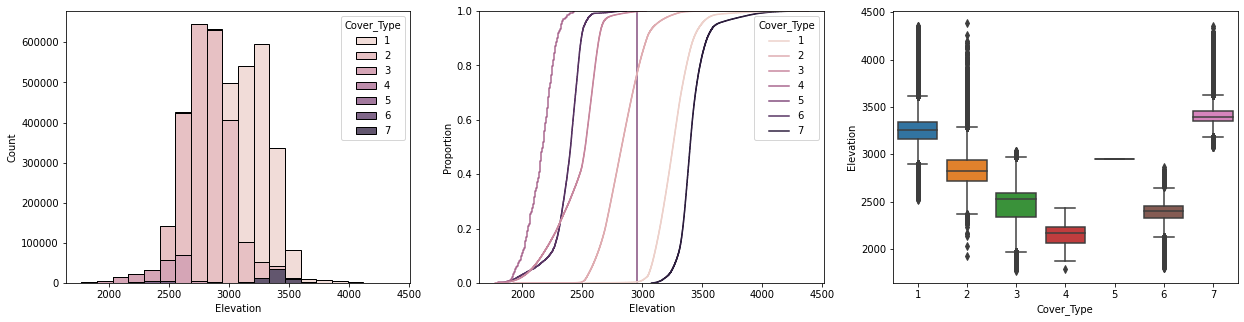

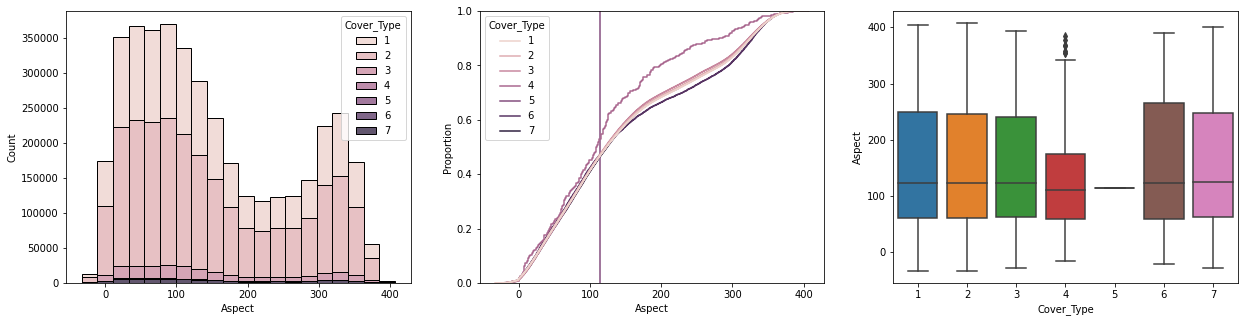

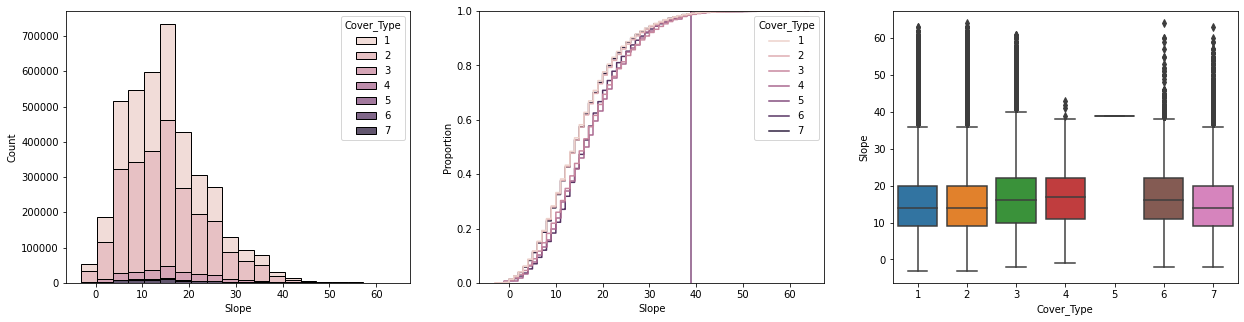

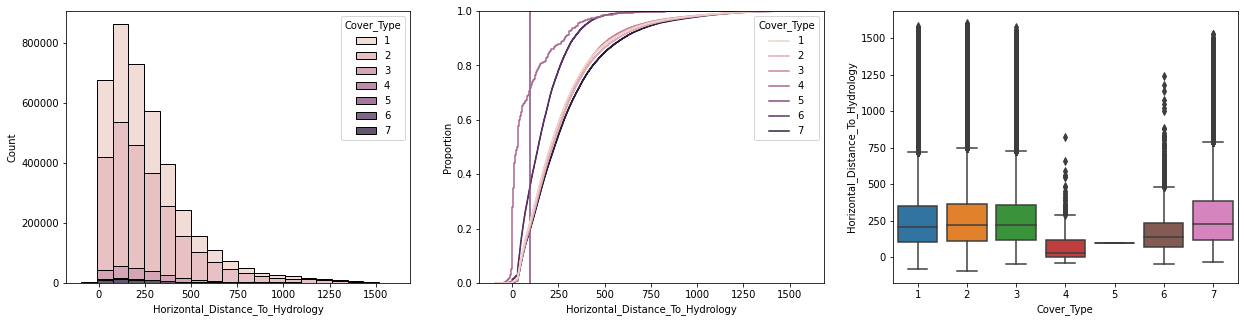

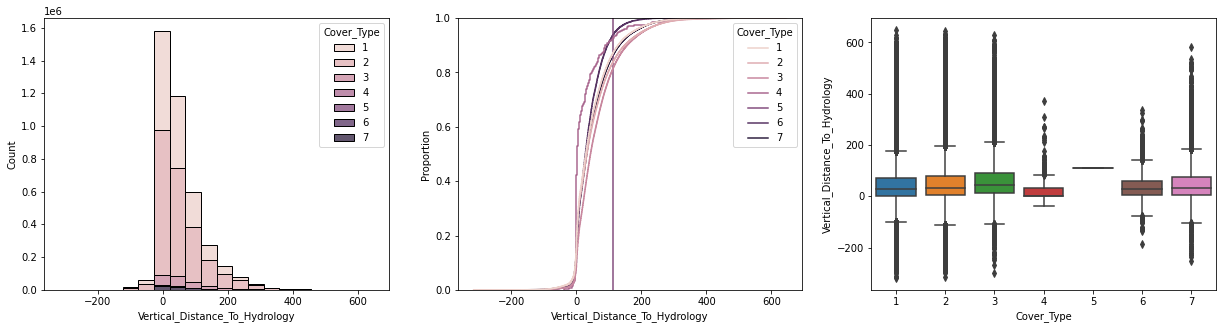

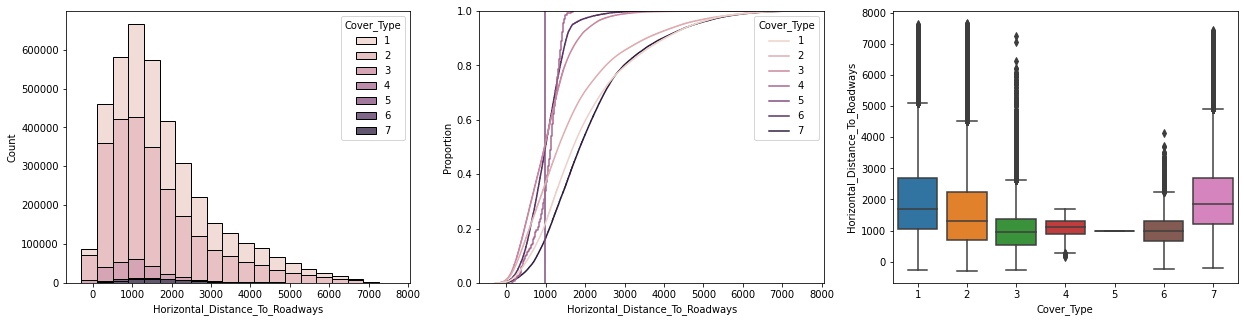

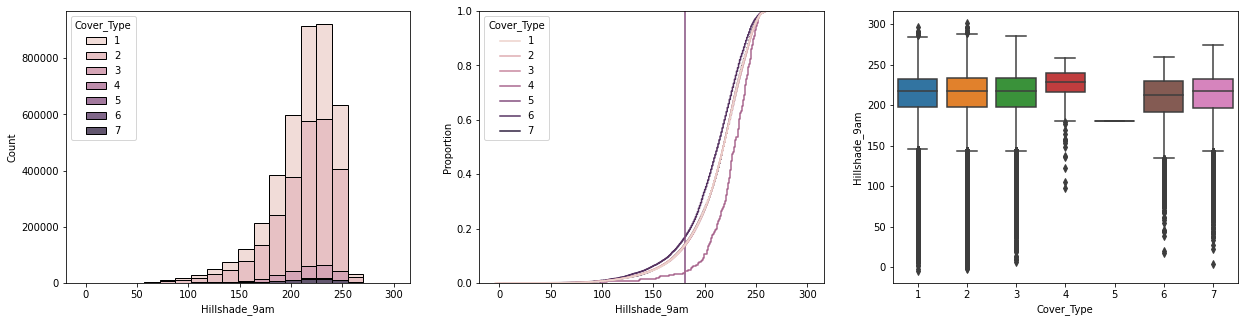

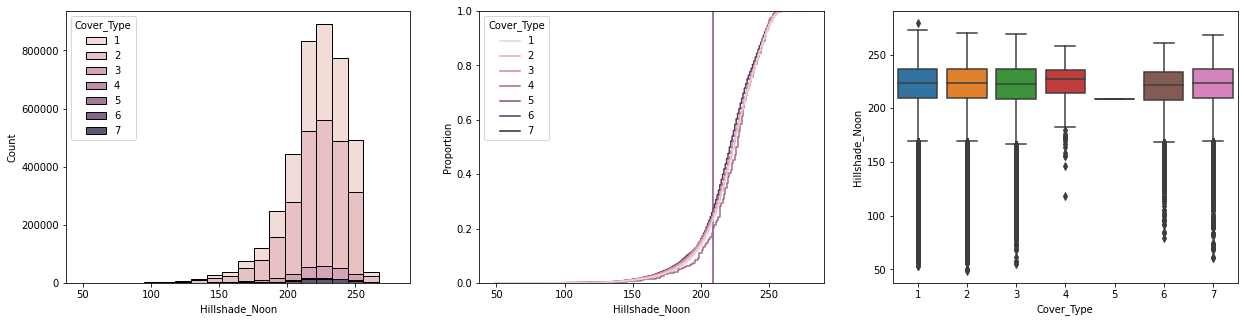

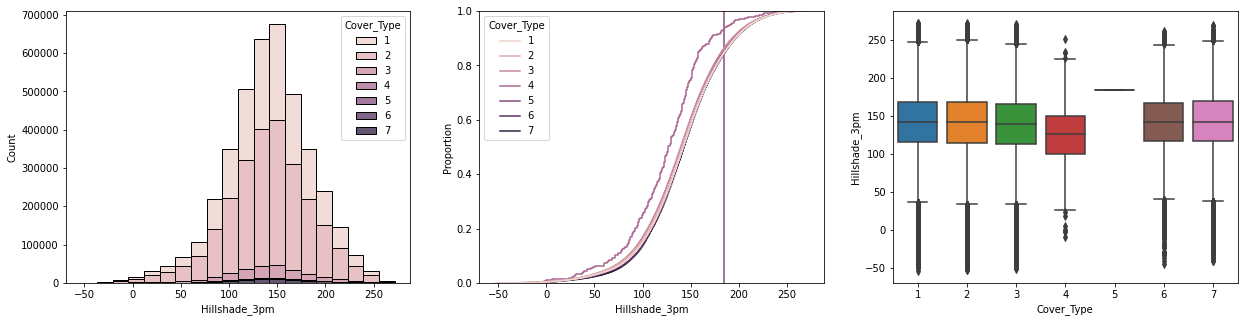

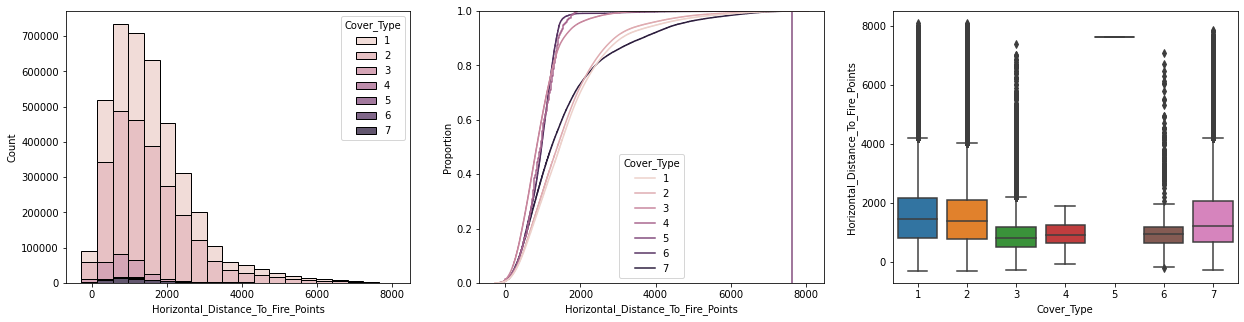

In [ ]:
for i in columns_continuous :
  fig, ax = plt.subplots(1, 3, figsize=(21, 5))

  sns.histplot(data = df, x = i, hue = "Cover_Type", multiple = "stack", bins = 20, ax = ax[0]);
  sns.ecdfplot(data = df, x = i, hue = "Cover_Type", ax = ax[1]);
  sns.boxplot(data = df, y = i, x = "Cover_Type", ax = ax[2]);
plt.show()

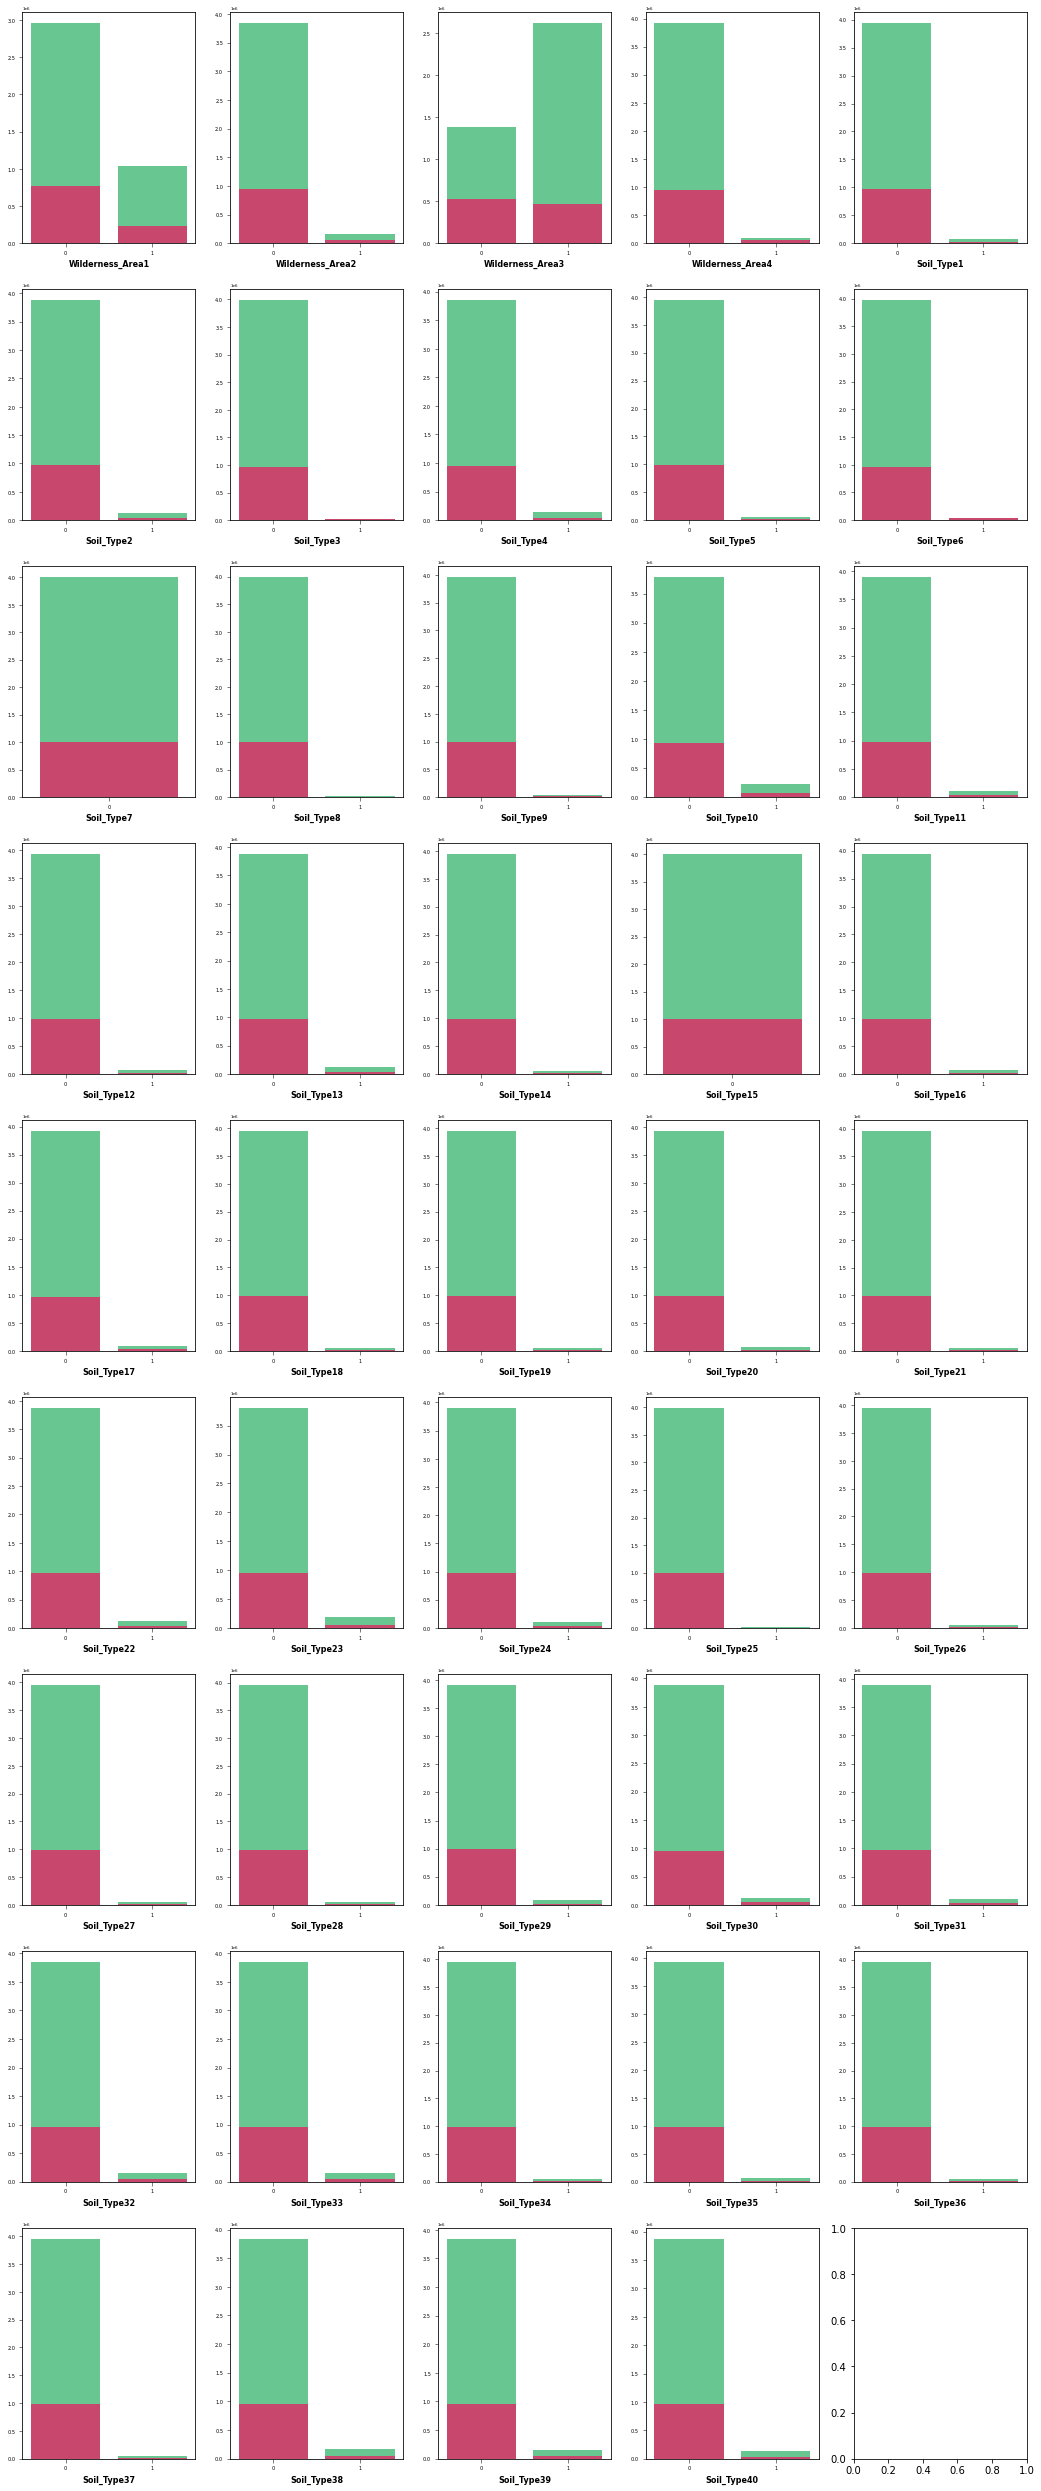

In [ ]:
# categorical feature distribution
ncols = 5
nrows = int(len(columns_categorical) / ncols + (len(columns_train) % ncols > 0)) 
fig, axes = plt.subplots(nrows, ncols, figsize=(18, 45))

for r in range(nrows):
    for c in range(ncols):
        if r * ncols + c >= len(columns_categorical):
            break
        col = columns_categorical[r * ncols + c]
        sns.countplot(x = df[col], ax = axes[r, c], color = '#58D68D', label = 'Train data')
        sns.countplot(x = test[col], ax = axes[r, c], color = '#DE3163', label = 'Test data')
        axes[r, c].set_ylabel('')
        axes[r, c].set_xlabel(col, fontsize = 8, fontweight = 'bold')
        axes[r, c].tick_params(labelsize = 5, width = 0.5)
        axes[r, c].xaxis.offsetText.set_fontsize(4)
        axes[r, c].yaxis.offsetText.set_fontsize(4)
plt.show()

## **5. Feature Engineering**

In [ ]:
# feature engineering
def feature_en(data, train = True) :
  data.drop(['Id', 'Soil_Type7', 'Soil_Type15'], axis = 1, inplace = True)

  data['Aspect'][data['Aspect'] < 0] += 360
  data['Aspect'][data['Aspect'] > 359] -= 360

  data.loc[data['Hillshade_9am'] < 0, 'Hillshade_9am'] = 0
  data.loc[data['Hillshade_Noon'] < 0, 'Hillshade_Noon'] = 0
  data.loc[data['Hillshade_3pm'] < 0, 'Hillshade_3pm'] = 0

  data.loc[data['Hillshade_9am'] > 255, 'Hillshade_9am'] = 255
  data.loc[data['Hillshade_Noon'] > 255, 'Hillshade_Noon'] = 255
  data.loc[data['Hillshade_3pm'] > 255, 'Hillshade_3pm'] = 255
  
  col_list = data.columns.to_list()

  # 딥러닝에서는 해당 칼럼 제거 고려
  soil_features = [x for x in col_list if x.startswith('Soil_Type')]
  data['Soil_Type_count'] = data[soil_features].sum(axis = 1)

  wilderness_features = [x for x in col_list if x.startswith('Wilderness_Area')]
  data['wilderness_area_count'] = data[wilderness_features].sum(axis = 1)

  # Manhhattan, Euclidean distance to Hydrology
  data['Manhattan_Distance_to_Hydrolody'] = np.abs(data['Horizontal_Distance_To_Hydrology']) + np.abs(data['Vertical_Distance_To_Hydrology'])
  ####### 적용시 주의 #######
  data['Euclidean_Distance_to_Hydrolody'] = (data['Horizontal_Distance_To_Hydrology'] ** 2 + data['Vertical_Distance_To_Hydrology'] ** 2) ** 0.5
  
  data['EVDtH'] = data.Elevation - data.Vertical_Distance_To_Hydrology
  data['EHDtH'] = data.Elevation - data.Horizontal_Distance_To_Hydrology * 0.2

  data['Hydro_Fire_1'] = data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Fire_Points']
  data['Hydro_Fire_2'] = abs(data['Horizontal_Distance_To_Hydrology'] - data['Horizontal_Distance_To_Fire_Points'])
  data['Hydro_Road_1'] = abs(data['Horizontal_Distance_To_Hydrology'] + data['Horizontal_Distance_To_Roadways'])
  data['Hydro_Road_2'] = abs(data['Horizontal_Distance_To_Hydrology'] - data['Horizontal_Distance_To_Roadways'])
  data['Fire_Road_1'] = abs(data['Horizontal_Distance_To_Fire_Points'] + data['Horizontal_Distance_To_Roadways'])
  data['Fire_Road_2'] = abs(data['Horizontal_Distance_To_Fire_Points'] - data['Horizontal_Distance_To_Roadways'])

  # 실험 후 삭제
  # data['Hillshade_Noon_is_bright'] = (data.Hillshade_Noon == 255).astype(int)
  # data['Hillshade_9am_is_zero'] = (data.Hillshade_9am == 0).astype(int)
  # data['hillshade_3pm_is_zero'] = (data.Hillshade_3pm == 0).astype(int)
  # data['Hillshade_3pm_is_zero'] = (data.Hillshade_3pm == 0).astype(int)
  # data['Highwater'] = (data.Vertical_Distance_To_Hydrology < 0).astype(int)
  # data['binned_aspect'] = [math.floor((v + 60) / 45.0) for v in data['Aspect']]
  # data['binned_aspect2'] = [math.floor((v + 180) / 30.0) for v in data['Aspect']]

  # XGboost일 경우 해당 칼럼 제거 고려
  # data.drop(['Aspect', 'Horizontal_Distance_To_Hydrology', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm'], axis = 1, inplace = True)

  # target label 5 & 4의 데이터가 극히 적어 제거
  if train :
    data = data[data['Cover_Type'] != 5]
    data = data[data['Cover_Type'] != 4]
  
  return data

df = feature_en(df)
df.reset_index(drop = True, inplace = True)

test = feature_en(test, train = False)
test.reset_index(drop = True, inplace = True)

pseudolabels = feature_en(pseudolabels)
pseudolabels.reset_index(drop = True, inplace = True)

df.shape, test.shape, pseudolabels.shape

((3999622, 65), (1000000, 64), (984709, 65))

## **6. Data Scaling**

In [ ]:
# Scaling 할(apply_col) / 하지 않을(not_apply_col) Column 구분
apply_col = ['Elevation', 'Slope', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points',
             'Soil_Type_count', 'wilderness_area_count', 'Manhattan_Distance_to_Hydrolody', 'Euclidean_Distance_to_Hydrolody', 'EVDtH', 'EHDtH',
             'Hydro_Fire_1', 'Hydro_Fire_2', 'Hydro_Road_1', 'Hydro_Road_2', 'Fire_Road_1', 'Fire_Road_2', 'Aspect', 'Horizontal_Distance_To_Hydrology',
             'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

not_apply_col = []
cols_list = df.columns.to_list()
for i in cols_list :
  if i not in apply_col and i != 'Cover_Type' :
    not_apply_col.append(i)

print(not_apply_col)

['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']


In [ ]:
# RobustScaling
scaler = RobustScaler()

df_sca = scaler.fit_transform(df[apply_col])
test_sca = scaler.transform(test[apply_col])
pseudolabels_sca = scaler.transform(pseudolabels[apply_col])

In [ ]:
df_sca_df = pd.DataFrame(df_sca, columns = apply_col)
test_sca_df = pd.DataFrame(test_sca, columns = apply_col)
pseudolabels_sca_df = pd.DataFrame(pseudolabels_sca, columns = apply_col)

df_sca_final = pd.concat([df_sca_df, df[not_apply_col], df['Cover_Type']], axis = 1)
test_sca_final = pd.concat([test_sca_df, test[not_apply_col]], axis = 1)
pseudolabels_sca_final = pd.concat([pseudolabels_sca_df, pseudolabels[not_apply_col], pseudolabels['Cover_Type']], axis = 1)

#df_sca_final = pd.concat([df_sca_final, pseudolabels_sca_final], axis=0)

df_sca_final.shape, test_sca_final.shape

((3999622, 65), (1000000, 64))

## **7. Export Data**

In [ ]:
SAVE_PATH = 'dir/'

df_sca_final.to_csv(SAVE_PATH + "train.csv", header = True, index = False)
test_sca_final.to_csv(SAVE_PATH + "test.csv", header = True, index = False)